In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#%matplotlib nbagg
%matplotlib inline
import pandas as pd
import os

config = tf.ConfigProto(
    gpu_options=tf.GPUOptions(
    allow_growth=True
    ))


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python3.5/dist-packages/matplotlib/__init__.py:911: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python3.5/dist-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


(3062, 17)


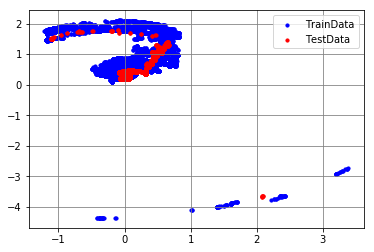

In [2]:
#----------TRAIN-------------#
target_path = '../data/LOG_G/fix_ball_robot/bk_stable/'
contents = os.listdir(target_path)
data = pd.DataFrame()
num = 0
for c in range(len(contents)):
    #print(target_path+contents[c])
    n_data = pd.read_csv(target_path+contents[c],header=None)
    data = pd.concat([data,n_data])
    
#----------TEST-------------#
#test_path = '../data/test/test_zenhoukou.csv'
#test_path = '../data/LOG_G/stable/log201807311344.csv'
#test_path = '../data/LOG_G/stable/log201807292107.csv'
#test_path = '../data/LOG_G/stable/log201807292213.csv'
#../data/LOG_G/stable/log201807311352.csv
#../data/LOG_G/stable/log201807311349.csv
#test_path = '../data/LOG_G/stable/log201807292116.csv'
#../data/LOG_G/stable/log201807311336.csv
#../data/LOG_G/stable/log201807292215.csv
#../data/LOG_G/stable/log201807292207.csv
test_path ='../data/test/convData_test_fix_axis.csv'
#test_path = '../data/LOG_G/stable/log201807311347.csv'
#test_path = '../data/LOG_G/stable/log201807311344.csv'
#test_path='../data/LOG_G/fix_ball_robot/bk_stable/log201808031448.csv'
#test_path='../data/LOG_G/fix_ball_robot/bk_stable/log201808031442.csv'
contents = os.listdir(target_path)
test_data = pd.read_csv(test_path,header=None)

plt.hold(True)
plt.grid(color='gray')
plt.scatter(data[1],data[0], s=10, c='blue',label='TrainData')
plt.grid(color='gray')
plt.scatter(test_data[1],test_data[0], s=10, c='red',label='TestData')
plt.legend()
print(test_data.shape)


In [3]:
hidden_size = [30,8]
batch_size = 100
iter_size = 50000
sess = tf.Session(config=config)
IN_size = 4
TAR_size = 3
INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]
print(final_output)
loss = tf.losses.mean_squared_error(TARGET,final_output)

'''
# モデルの定義
IN_size = 6
TAR_size = 4
INPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)
TARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)

hidden_size = [50 ,10]
batch_size = 100
iter_size = 100000

#　隠れ層の作成 （last layerに直結）
weights = []
biases = []
layers = []
tmp_size = IN_size
last_layer = INPUT
for hsize in hidden_size:
    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))
    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))
    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数
    tmp_size = hsize
    last_layer = layers[-1]
    print(layers[-1])
#　出力層
weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))
biases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))
layers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))
final_output = layers[-1]

loss = tf.losses.mean_squared_error(TARGET,final_output)
'''

Tensor("Relu:0", shape=(?, 30), dtype=float32)
Tensor("Relu_1:0", shape=(?, 8), dtype=float32)
Tensor("Add_2:0", shape=(?, 3), dtype=float32)


'\n# モデルの定義\nIN_size = 6\nTAR_size = 4\nINPUT = tf.placeholder(shape=[None, IN_size], dtype=tf.float32)\nTARGET = tf.placeholder(shape=[None, TAR_size], dtype=tf.float32)\n\nhidden_size = [50 ,10]\nbatch_size = 100\niter_size = 100000\n\n#\u3000隠れ層の作成 （last layerに直結）\nweights = []\nbiases = []\nlayers = []\ntmp_size = IN_size\nlast_layer = INPUT\nfor hsize in hidden_size:\n    weights.append(tf.Variable(tf.random_normal(shape=[tmp_size, hsize], stddev=10.0)))\n    biases.append(tf.Variable(tf.random_normal(shape=[hsize], stddev=10.0)))\n    layers.append(tf.nn.relu(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))) # 活性化関数\n    tmp_size = hsize\n    last_layer = layers[-1]\n    print(layers[-1])\n#\u3000出力層\nweights.append(tf.Variable(tf.random_normal(shape=[tmp_size, TAR_size], stddev=10.0)))\nbiases.append(tf.Variable(tf.random_normal(shape=[TAR_size], stddev=10.0)))\nlayers.append(tf.add(tf.matmul(last_layer, weights[-1]), biases[-1]))\nfinal_output = layers[-1]\n\nloss = tf.l

In [4]:
# 重みのrestore
saver = tf.train.Saver()
predicts_sess = tf.Session(config=config)
ckpt = tf.train.get_checkpoint_state('./')
if ckpt == None:
    print('!!!!!!!WEIGHTS NOT FOUND!!!!!!')

saver.restore(predicts_sess, './model.ckpt')

INFO:tensorflow:Restoring parameters from ./model.ckpt


In [5]:
test_data.columns = ['l_bx','l_by','lc_gx','lc_gy','g_bx','g_by','g_pole0x','g_pole0y','g_pole1x','g_pole1y','g_px','g_py','g_pth','ljx','ljy','rjx','rjy']

s_INPUT = np.array(test_data.iloc[:,0:IN_size])
print(s_INPUT.shape)
s_ANS = np.array(test_data.iloc[:,13:16])
print(s_ANS)

#pred = np.empty((0,3),np.float32)
res = np.empty((0,3),np.float32)
for i in range(len(s_INPUT)):
    s_input = np.array([s_INPUT[i]])
    s_ans = np.array([s_ANS[i]])
    p = predicts_sess.run(final_output, feed_dict={INPUT: s_input})
    test_loss = predicts_sess.run(loss, feed_dict={INPUT: s_input,TARGET:s_ans})
    
    res = np.append(res, p, axis=0)

    #col = np.c_[test_loss, s_input]
    #pred = np.append(pred, col, axis=0)
print(res)    
#p_pred = pd.DataFrame(pred,columns=list('pxy'))
#sorted_data = p_pred.sort_values(by='p',ascending=False) #p列において値の大きい順にソート
#print(len(pred))

(3062, 4)
[[ 0.         -0.01031494  0.        ]
 [ 0.         -0.18557739  0.        ]
 [ 0.         -0.18557739  0.        ]
 ...
 [ 0.         -0.5670166   0.        ]
 [ 0.         -0.34020996  0.        ]
 [ 0.         -0.1340332   0.        ]]
[[-0.58093274 -0.6204132   0.9159259 ]
 [-0.58090544 -0.62040126  0.9158934 ]
 [-0.58090544 -0.62040126  0.9158934 ]
 ...
 [-0.21944818 -0.71534497  0.07051528]
 [-0.22218153 -0.71239895  0.07088292]
 [-0.22218153 -0.71239895  0.07088292]]


In [6]:
'''
plt.hold(True)
plt.scatter(data[1]/100,data[0]/100, s=10, c='palegreen',label='TrainData')

thresh = 1

#----------TEST-------------#
for t in range(len(pred)):
    if pred[t][0] < thresh: #まあほぼ正解
        plt.scatter(pred[t][2],pred[t][1], s=10, c='lightcoral')
    else: #失敗
        plt.scatter(pred[t][2],pred[t][1], s=10, c='c')
'''

"\nplt.hold(True)\nplt.scatter(data[1]/100,data[0]/100, s=10, c='palegreen',label='TrainData')\n\nthresh = 1\n\n#----------TEST-------------#\nfor t in range(len(pred)):\n    if pred[t][0] < thresh: #まあほぼ正解\n        plt.scatter(pred[t][2],pred[t][1], s=10, c='lightcoral')\n    else: #失敗\n        plt.scatter(pred[t][2],pred[t][1], s=10, c='c')\n"

In [7]:
def mean_sq_loss(pre, ans):
    loss = np.sum(np.sqrt((ans[:,0]-pre[:,0])**2+(ans[:,1]-pre[:,1])**2+(ans[:,2]-pre[:,2])**2))/ len(pre)
    print('loss : '  +str(loss) )
    bosuu = 12286 * 0.8
    min_loss = np.sum(np.sqrt((ans[:,0]-pre[:,0])**2+(ans[:,1]-pre[:,1])**2+(ans[:,2]-pre[:,2])**2))/ bosuu
    print('min_loss : '+str(min_loss))
    return loss

# 確認用配列
ans  = np.zeros( (2,10),dtype=np.float32) + 0.0
pre  = np.zeros( (2,10),dtype=np.float32) + 1.0
pre2 = np.zeros( (2,10),dtype=np.float32) + 0.5
# 動作確認
mean_sq_loss(pre,ans)
mean_sq_loss(pre2,ans)

loss : 1.7320507764816284
min_loss : 0.0003524439965166914
loss : 0.8660253882408142
min_loss : 0.0001762219982583457


0.8660253882408142

[-0.01031494 -0.18557739 -0.18557739 ... -0.5670166  -0.34020996
 -0.1340332 ]
-------------------
[-0.6204132  -0.62040126 -0.62040126 ... -0.71534497 -0.71239895
 -0.71239895]
0.27127392371280423


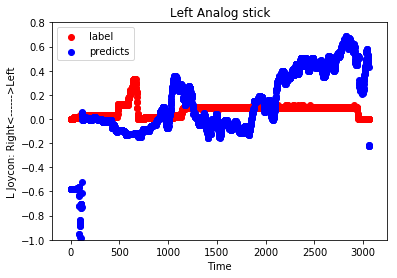

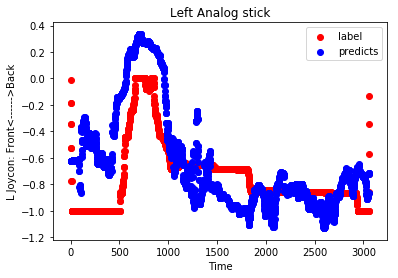

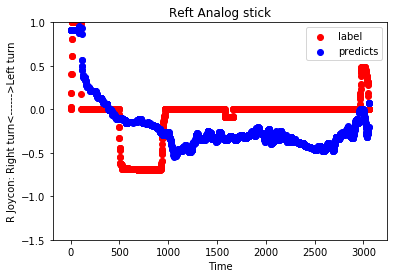

In [8]:
#heikinloss = mean_sq_loss(res, s_ANS)

t = np.empty(len(s_INPUT))
l = np.array([list(range(len(s_INPUT)))])
t[:]=l


plt.figure(1)
plt.scatter(t,s_ANS[:,0],color='r', label='label') #ラベルjx
plt.scatter(t,res[:,0],color='b', label='predicts')    #予測
plt.ylim(-1,0.8)
plt.xlabel("Time")
plt.ylabel("L Joycon: Right<------>Left")
plt.title('Left Analog stick')
plt.savefig("test_rightleft.png")
plt.legend()

print(s_ANS[:,1])
print('-------------------')
print(res[:,1])
plt.figure(2)
plt.scatter(t,s_ANS[:,1],color='r', label='label') #ラベルjx
plt.scatter(t,res[:,1],color='b', label='predicts')    #予測
#plt.ylim(-1.5,0.5)
plt.xlabel("Time")
plt.ylabel("L Joycon: Front<------>Back")
plt.title('Left Analog stick')
plt.savefig("test_frontback.png")
plt.legend()

plt.figure(3)
plt.title('Reft Analog stick')
plt.scatter(t,s_ANS[:,2],color='r', label='label') #ラベルjx
plt.scatter(t,res[:,2],color='b', label='predicts')    #予測
plt.ylim(-1.5,1)
plt.xlabel("Time")
plt.ylabel("R Joycon: Right turn<------>Left turn")
plt.savefig("test_kakudai.png")


plt.legend()

heikinloss = np.sum(np.sqrt((s_ANS[:,0]-res[:,0])**2+(s_ANS[:,1]-res[:,1])**2+(s_ANS[:,2]-res[:,2])**2))/6000
print(heikinloss)